In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import matplotlib.pyplot as plt
import random

import wandb
import os

In [2]:
spectra = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

# Plotting Function Definitions:
---

In [52]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))

  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [49]:
def plot_results(real_spectra, fake_spectra, labels, idx=[0,5], window=300, cutoff = 0.5):
  """
  Plot and compare real and synthetic spectra within a specified index range.

  Takes in real, noisy, and synthetic spectra and plots them for comparison.
  Computes and prints the weighted cosine similarity between the real spectrum and 
  both the noisy and synthetic spectra.

  Args:
      real_spectra (list of list of float): List of real spectra, where each spectrum is a list of intensity values.
      fake_spectra (list of list of float): List of synthetic spectra generated by decoder.
      labels (list of str): List of chemical name labels corresponding to each spectrum.
      idx (list of int, optional): Range of indices to plot. Default is [0, 10].
      window (int, optional): Highest m/z to plot for each spectrum. Default is 300.
      cutoff (float, optional): Intensity cutoff threshold to filter out low-intensity noise. Default is 0.5.
  """
  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plot spectra within the specified index range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:
      # Define the x-axis range
      numbers = range(0, window)
      
      # Scale the real spectrum so highest peak is 100
      input_frequencies = real_spec.copy()
      input_max = max(input_frequencies)
      scaled_input = [num/input_max * 100 for num in input_frequencies]

      # Scale the synthetic spectrum so highest peak is 100
      out_clone = fake_spec.copy()
      output_max = max(out_clone)
      scaled_out = [num/output_max * 100 for num in out_clone]
      out_frequencies = [0 if num < cutoff else num for num in scaled_out]

      weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, input_frequencies)

      # Create a plot with 2 subplots for real and synthetic spectra
      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, scaled_input[:window])
      ax[0].set_title(f'True {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity between true spectrum and output spectrum is: ', round(float(weighted_cosine_similarity), 2))
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

# Model Definition:
---

VAE based on model from this paper: https://ieeexplore.ieee.org/abstract/document/10463452

Using this tutorial for help: https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [4]:
class VAE(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
      nn.Linear(915,64),
      nn.ReLU(),
    )

    self.mean_layer = nn.Linear(64, 2)
    self.logvar_layer = nn.Linear(64, 2)

    self.decoder = nn.Sequential(
      nn.Linear(2,64),
      nn.ReLU(),
      nn.Linear(64,915),
    )
  
  def encode(self, x):
    x = self.encoder(x)
    mean, logvar = self.mean_layer(x), self.logvar_layer(x)
    return mean, logvar

  def reparameterization(self, mean, log_var):
    eps = torch.randn_like(log_var)
    z = mean + log_var * eps
    return z
  
  def decode(self, z):
    return self.decoder(z)
  
  def forward(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterization(mean, logvar)
    x_hat = self.decode(z)
    return x_hat, mean, logvar

# Generate Dataset:
---

In [37]:
def generate_dataset(true_spec_data, spectra_names):
    true_spectra_train = []
    train_name_encodings = []

    true_spectra_test = []
    test_name_encodings = []

    spectra_copy = true_spec_data.copy()

    for spec in spectra_copy:
        # using same chemical used in dynamical systems model, Benzyl Benzoate
        if list(set(spectra_names))[list(spec[915:965]).index(1)] == 'Benzyl Benzoate':
            true_spectra_test.append(spec[:915])
            test_name_encodings.append(spec[915:965])
        else:
            true_spectra_train.append(spec[:915])
            train_name_encodings.append(spec[915:965])

    true_spectra_train_tensor = torch.tensor(true_spectra_train, dtype=torch.float32)
    train_dataset = TensorDataset(true_spectra_train_tensor, torch.tensor(train_name_encodings))
    train_dataset = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

    true_spectra_test_tensor = torch.tensor(true_spectra_test, dtype=torch.float32)
    test_dataset = TensorDataset(true_spectra_test_tensor, torch.tensor(test_name_encodings))
    test_dataset = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

    return train_dataset, test_dataset

# Train Model:
---

In [10]:
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'mass_spec',
    'gpu':True,
    'threads':1,
}

# Set WANDB_NOTEBOOK_NAME environment variable
os.environ['WANDB_NOTEBOOK_NAME'] = 'variational_autoencoder.ipynb'

In [39]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [36]:
# create list of chemical names
spectra_names = [chem.split('.')[0] for chem in spectra.columns]

# separate spectrum data from chemical name encodings
true_spec_data = spectra.values.T 
encoded_names = torch.tensor(spectra[:][915:965].values, dtype=torch.float32).T

Need to update generate_dataset function so it uses same test data as our decoupled autooencoders.

In [35]:
train_dataset, test_dataset = generate_dataset(true_spec_data, spectra_names)

0 572


Pytorch implementation from: https://discuss.pytorch.org/t/elbo-loss-in-pytorch/137431/4

In [72]:
class VAE_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, x_hat, logvar, mean):
        mse = F.mse_loss(x_hat, x)
        kld = -0.5 * torch.sum(1+logvar - mean.pow(2) - logvar.exp())
        return mse + kld

In [73]:
lr = .001
model = VAE()
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
criterion = VAE_loss()

epochs = 100

model_output = []
input_spectra = []
true_spectra = []
output_labels = []

config['learning_rate'] = lr


run_with_wandb(config, truth='variational_autoencoder')
for epoch in range(epochs):
    epoch_loss = 0
    for batch, labels in train_dataset:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        x_hat, mean, logvar = model(batch)
        loss = criterion(x_hat, batch, logvar, mean)
        epoch_loss += loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if (epoch+1)==epochs:
            chem_names = [sorted(list(set(spectra_names)))[list(encoding).index(1)] for encoding in labels]
            for output_spectrum, true_spectrum, chem_name in zip(x_hat, batch, chem_names):
                model_output.append(output_spectrum)
                true_spectra.append(true_spectrum)
                output_labels.append(chem_name)

    if (epoch+1) % 10 == 0:
        average_loss = epoch_loss/len(train_dataset)
        wandb.log({"Variational Autoencoder Training Loss": average_loss})
        print('Epoch[{}/{}], train loss: {}'.format(epoch+1, epochs, round(float(average_loss.detach().numpy()), 6), 6))

wandb.finish()

Using device: cuda
Epoch[10/100], train loss: 18.809141
Epoch[20/100], train loss: 18.420029
Epoch[30/100], train loss: 18.228157
Epoch[40/100], train loss: 18.124384
Epoch[50/100], train loss: 18.144682
Epoch[60/100], train loss: 18.083765
Epoch[70/100], train loss: 18.107426
Epoch[80/100], train loss: 17.881584
Epoch[90/100], train loss: 17.659843
Epoch[100/100], train loss: 17.497576


Variational Autoencoder Training Loss,█▆▅▄▄▄▄▃▂▁
Variational Autoencoder Training Loss,17.49758


In [ ]:
# plotting_true_spectra = [vec.detach().numpy() for vec in true_spectra]
# plotting_input_spectra = [vec.detach().numpy() for vec in input_spectra]
# output_spectra = [vec.detach().numpy() for vec in model_output]

# plot_results_with_input(plotting_true_spectra, plotting_input_spectra, output_spectra, output_labels, idx=[0,3])

In [75]:
model.eval()
test_output = []
test_true_spectra = []
test_output_labels = []
test_loss = 0

with torch.no_grad(): 
    for batch, labels in test_dataset:
        test_x_hat, test_mean, test_logvar = model(batch)

        loss = criterion(test_x_hat, batch, logvar, mean)
        test_loss+=loss

        chem_names = [sorted(list(set(spectra_names)))[list(encoding).index(1)] for encoding in labels]
        for output_spectrum, true_spectrum, chem_name in zip(test_x_hat, batch, chem_names):
            test_output.append(output_spectrum)
            test_true_spectra.append(true_spectrum)
            test_output_labels.append(chem_name)

    average_loss = test_loss/len(test_dataset)
    print('Loss =', average_loss)

Loss = tensor(13.3857)


Weighted cosine similarity between true spectrum and output spectrum is:  0.24


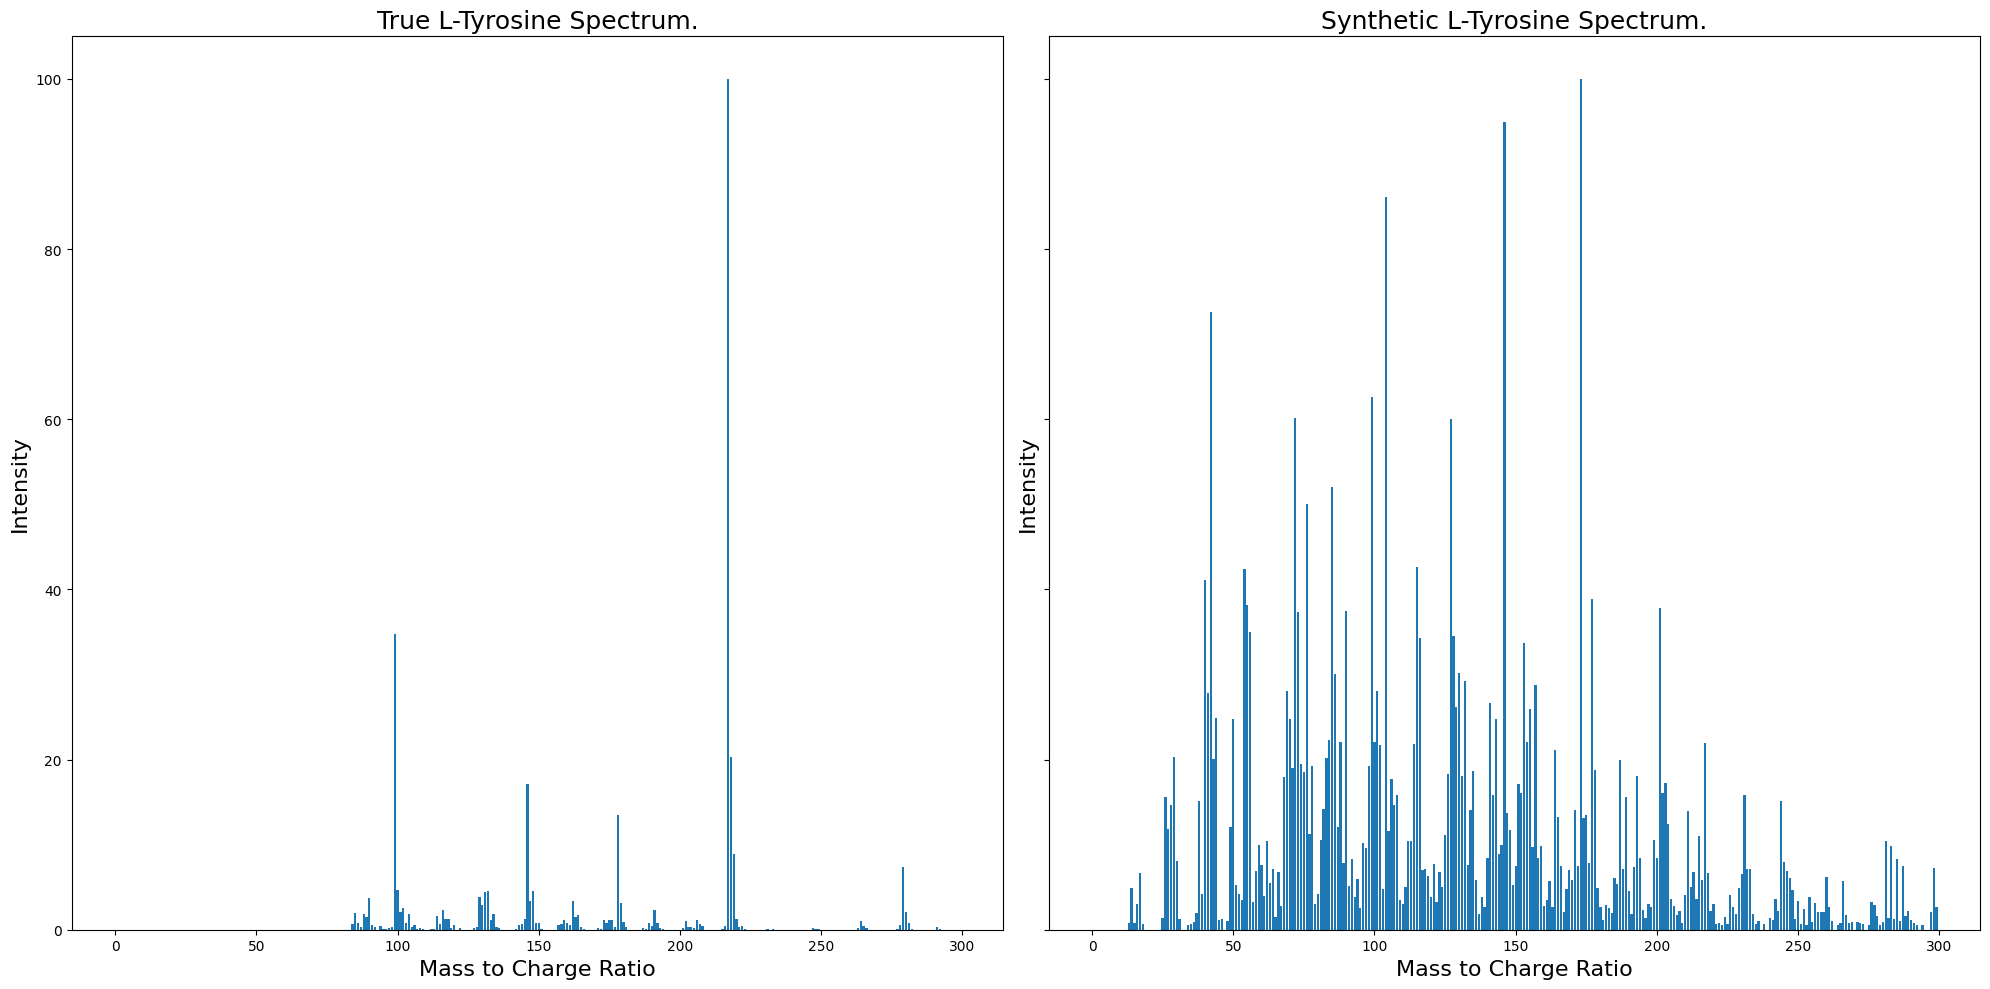

Weighted cosine similarity between true spectrum and output spectrum is:  0.24


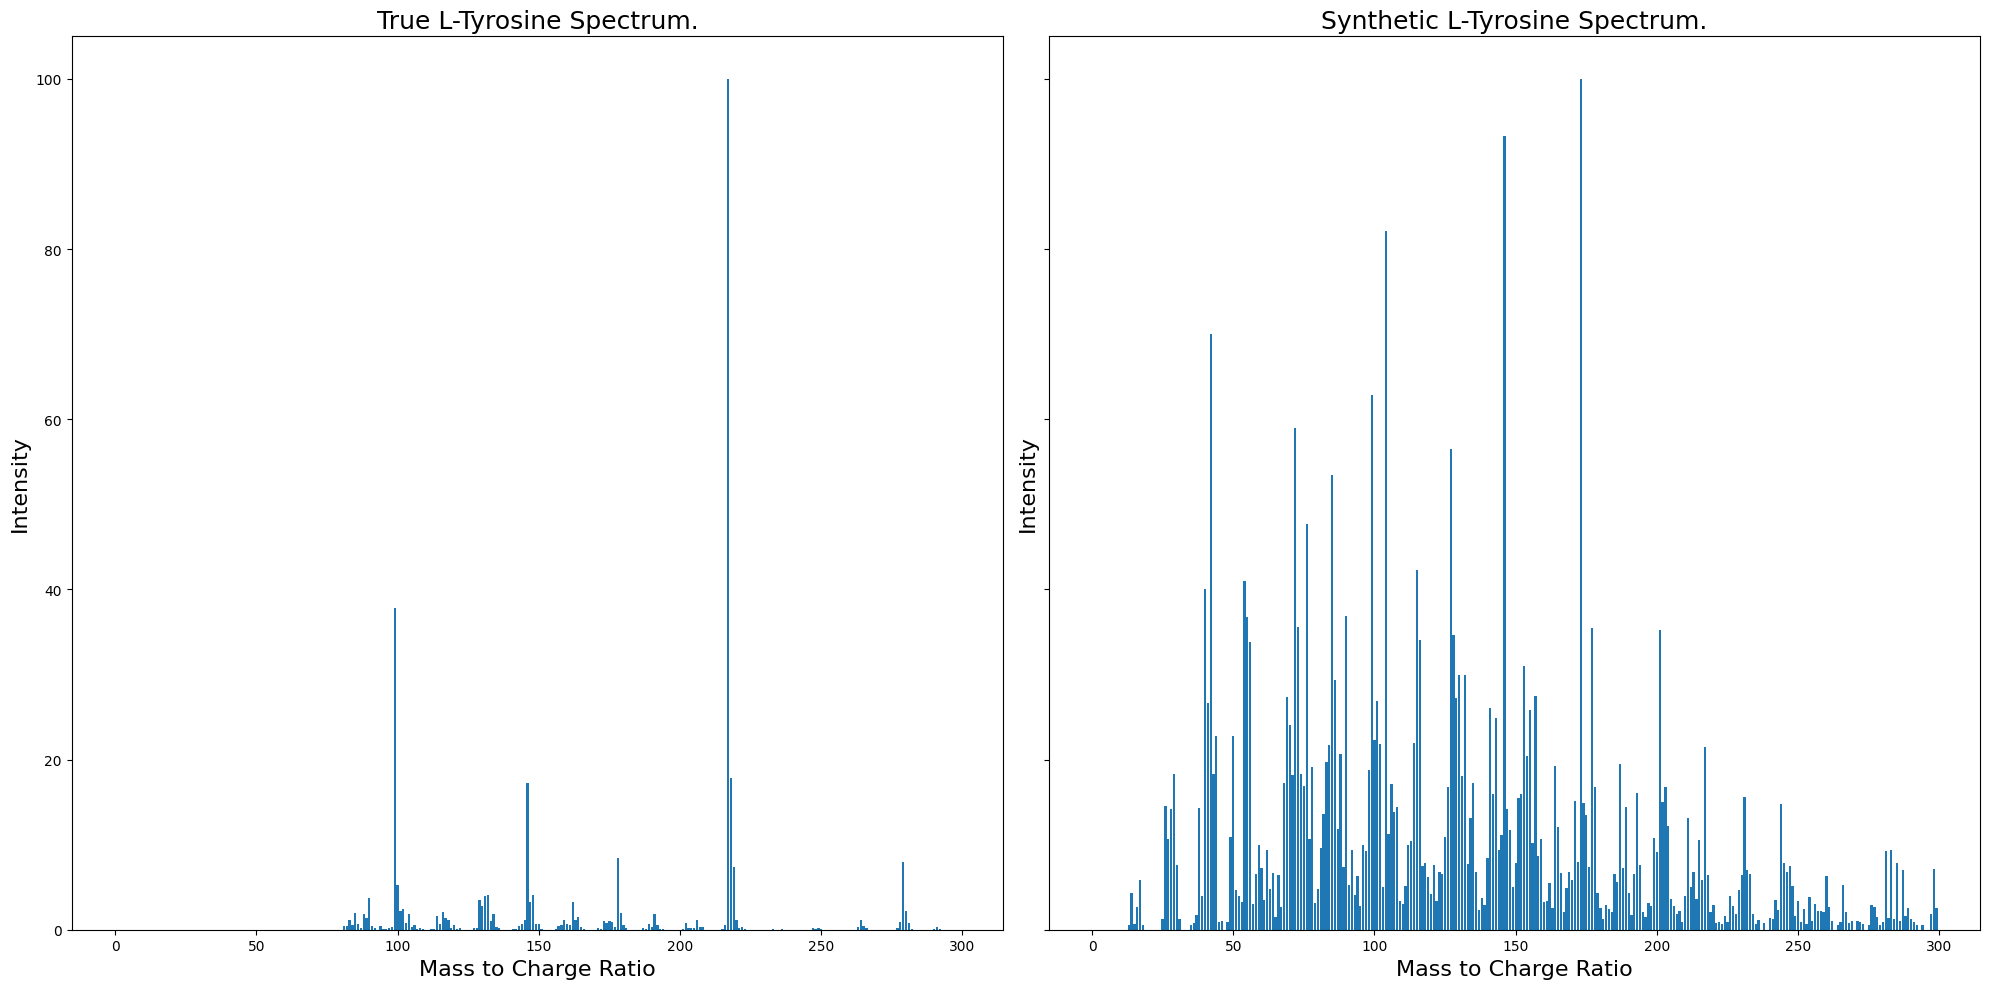

Weighted cosine similarity between true spectrum and output spectrum is:  0.2


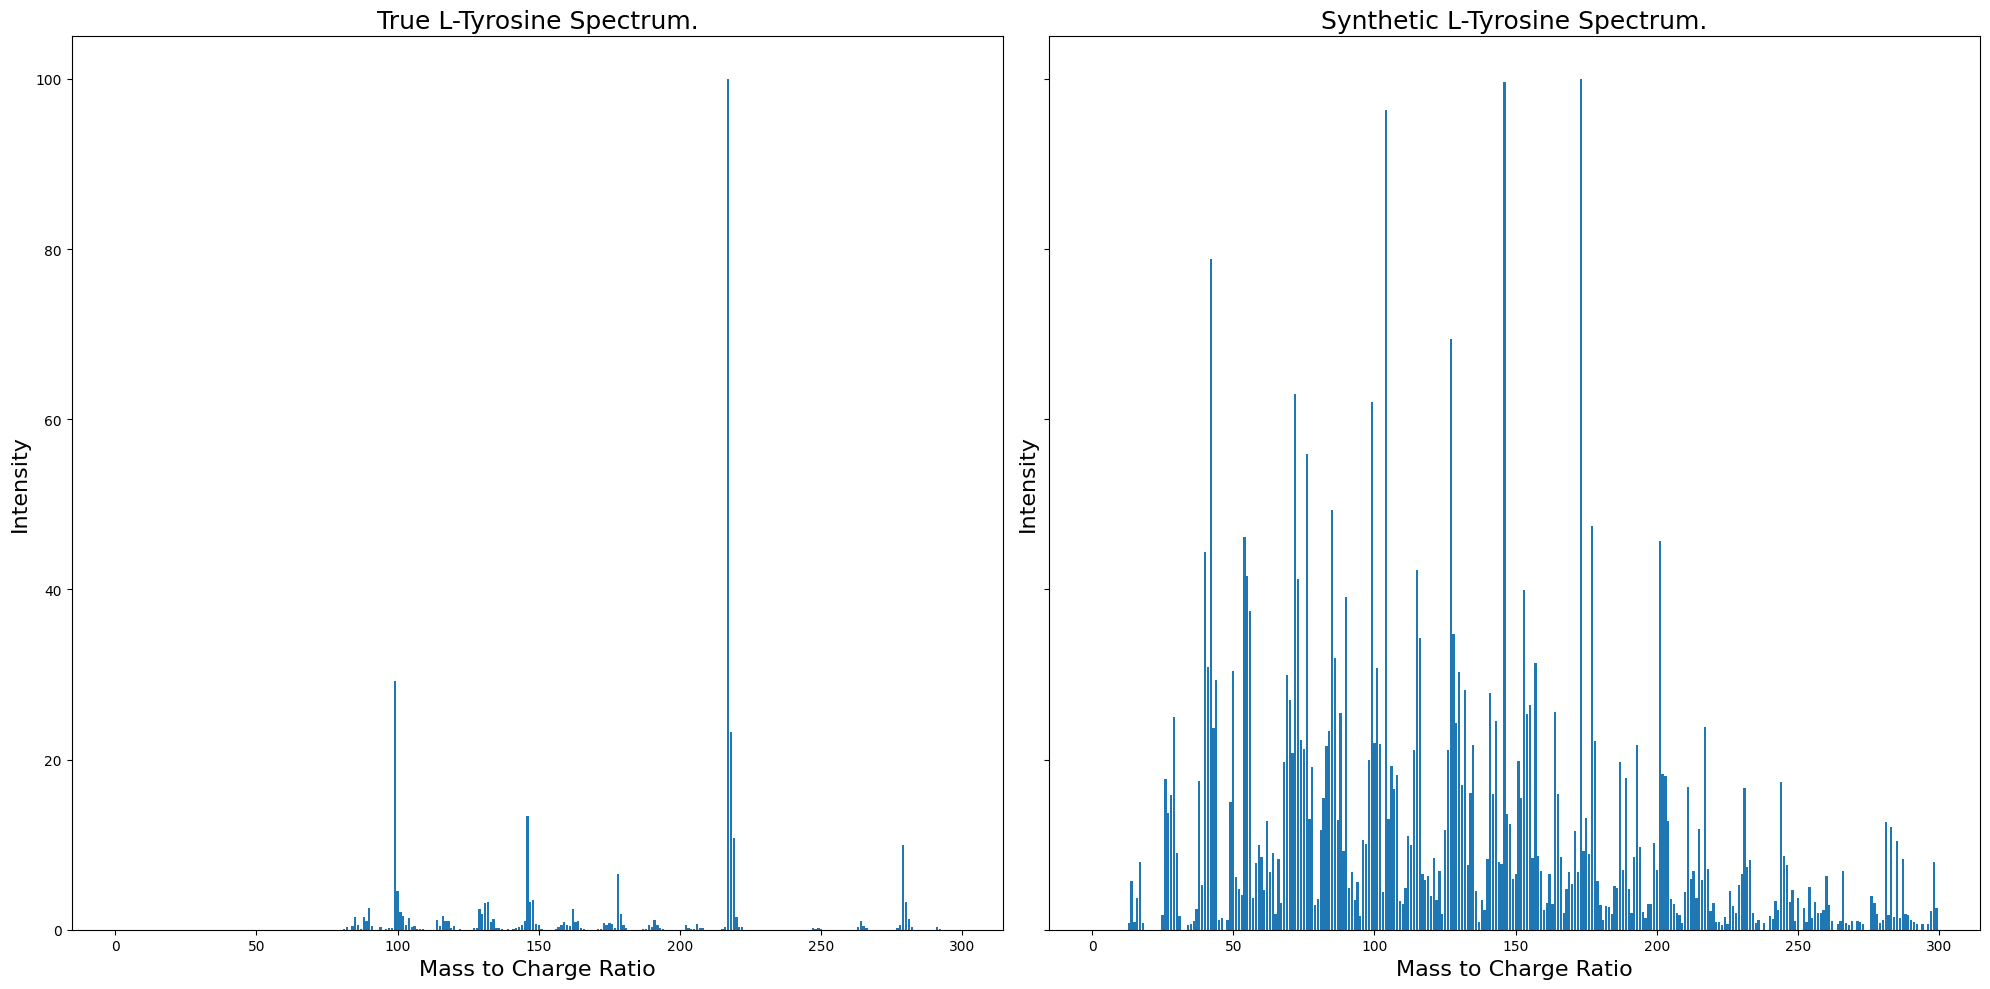

In [76]:
plotting_true_spectra = [vec.detach().numpy() for vec in test_true_spectra]
output_spectra = [vec.detach().numpy() for vec in test_output]

plot_results(plotting_true_spectra, output_spectra, test_output_labels, idx=[0,3])